## Exercise 3

<strong>Overview</strong>

Identification of drugs for Squamous cell carcinoma of lung using network medicine approach.

Provided are the human interactome, a list of known disease genes and a list of drugs along with their targets. Identify which of the given drugs would be the best possible treatment for the disease. Assuming that the best drug would be the one that directly targets the disease genes or genes close to the known disease genes, use network proximity between the drug targets and the disease genes to identify potential therapies.

<strong>Tasks:</strong>
- Read the human interactome as network. Explore the network and assess its topological properties (number of nodes andedges, density, number of connected components, modularity etc).
- Extract the sub-network of the disease genes and assess its topological properties.
- Are all the disease genes connected in the human interactome? If not, use Steiner tree to identify additional genes that may be required to connect the disconnected disease genes, if any. 
- Extract sub-network from the human interactome consisting of the known disease genes and the additional genes identified from Steiner tree. These total set of genes will henceforth be called the extended disease gene list.
- Calculate the network separation between the targets of each drug and the disease genes. Based on the separation distance identify which drug would have the most therapeutic effect.
- Does the drug with highest therapeutic potential change if the proximity is calculated using known disease genes and the extended disease genes?
- Are the identified drugs currently in use for the disease in question? 

<strong>Files to use:</strong>
- Network: Data/Exercise3_STRING_PPI.csv
- Disease genes: Data/Exercise3_Disease_genes.csv
- Drug list and their targets: Data/Exercise3_Drug_Targets.csv

<strong>Hints:</strong>
- While using <code>steiner_tree</code>, use all the known disease genes as <code>terminal_nodes</code>. The resultant tree will contain the known disease genes as terminal nodes and some additional nodes as Steiner nodes. All the nodes of this tree could be used as the extended disease gene list.
- To view drug related information, you could use DrugBank and OpenTargets platforms.

In [1]:
# Upload Python modules
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms.approximation import steiner_tree
import separation # from Barabasi-lab
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Part A
- Read the human interactome as network. Explore the network and assess its topological properties (number of nodes and edges, density, number of connected components, modularity etc).

In [2]:
# Reading the network
edge_list = pd.read_csv("Data/Exercise3_STRING_PPI.csv")
edge_list.head()

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,Node1_geneSymbol,Node2_geneSymbol
0,9606.ENSP00000000233,9606.ENSP00000493357,0,0,0,56,53,0,433,471,ARF5,CYTH2
1,9606.ENSP00000000233,9606.ENSP00000371175,0,0,0,47,296,0,403,594,ARF5,GGA1
2,9606.ENSP00000000233,9606.ENSP00000354878,0,0,0,42,0,500,0,513,ARF5,KIF21A
3,9606.ENSP00000000233,9606.ENSP00000310226,0,0,0,109,110,500,154,648,ARF5,RAB1B
4,9606.ENSP00000000233,9606.ENSP00000258098,0,0,0,0,0,0,497,501,ARF5,RAB11FIP5


array([[<Axes: title={'center': 'combined_score'}>]], dtype=object)

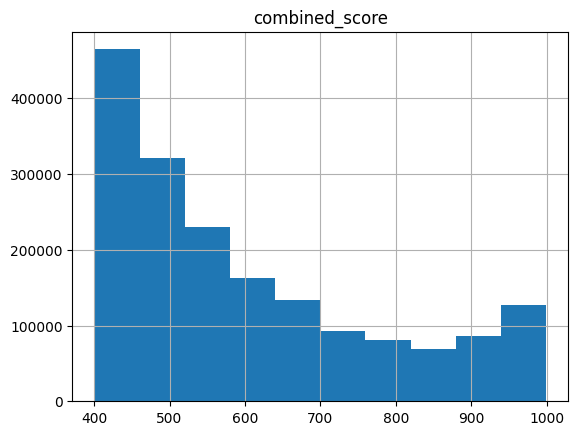

In [3]:
# edge_list = edge_list[edge_list["combined_score"] > 700]
edge_list.hist("combined_score")

In [4]:
# Creating network from edge list 
STRING_PPI = nx.from_pandas_edgelist(df = edge_list,
                            source = "Node1_geneSymbol", 
                            target = "Node2_geneSymbol")
# STRING_PPI_pos = nx.spring_layout(STRING_PPI, seed = 20)
# nx.draw(STRING_PPI, with_labels = False, pos = STRING_PPI_pos, node_size = 1, node_color = "#1BB3F5")

In [5]:
# Get basic properties of the network
print("Number of nodes:", STRING_PPI.number_of_nodes())
print("Number of edges:", STRING_PPI.number_of_edges())
print("Number of connected components:", nx.number_connected_components(STRING_PPI))
print("Network modularity:", nx.algorithms.community.modularity(STRING_PPI, nx.connected_components(STRING_PPI)))
print("Number of isolated nodes:", nx.number_of_isolates(STRING_PPI))
print("Number of self loops:", nx.number_of_selfloops(STRING_PPI))

Number of nodes: 18876
Number of edges: 884457
Number of connected components: 2
Network modularity: 2.2612718750286577e-06
Number of isolated nodes: 0
Number of self loops: 6


In [6]:
# Extract the largest connected component
STRING_PPI = list(STRING_PPI.subgraph(c).copy() for c in sorted(nx.connected_components(STRING_PPI), key = len, reverse = True))[0]
print(len(STRING_PPI.nodes()), len(STRING_PPI.edges()))
# nx.draw(STRING_PPI, with_labels = False, node_size = 1, node_color = "#1BB3F5")

18874 884456


In [7]:
# Remove the self-loops
STRING_PPI.remove_edges_from(list(nx.selfloop_edges(STRING_PPI)))

In [8]:
# Get basic properties of the network
print("Number of nodes:", STRING_PPI.number_of_nodes())
print("Number of edges:", STRING_PPI.number_of_edges())
print("Number of connected components:", nx.number_connected_components(STRING_PPI))
print("Network modularity:", nx.algorithms.community.modularity(STRING_PPI, nx.connected_components(STRING_PPI)))
print("Number of isolated nodes:", nx.number_of_isolates(STRING_PPI))
print("Number of self loops:", nx.number_of_selfloops(STRING_PPI))
# print("Diameter of network:", nx.diameter(STRING_PPI))
# print("Average clustering coefficient:", nx.average_clustering(STRING_PPI))
# print("Average shortest path length:", nx.average_shortest_path_length(STRING_PPI))
print("Network density:", nx.density(STRING_PPI))

Number of nodes: 18874
Number of edges: 884450
Number of connected components: 1
Network modularity: 0.0
Number of isolated nodes: 0
Number of self loops: 0
Network density: 0.004965904820114568


### Part B
- Extract the sub-network of the disease genes and assess its topological properties.

In [9]:
# Read the disease gene list
disease_genes = pd.read_csv("Data/Exercise3_Disease_genes.csv")
disease_genes = disease_genes.loc[:,"x"].tolist()
print("Disease genes: ", disease_genes)
print("Number of disease genes: ", len(disease_genes))

Disease genes:  ['ACVR1C', 'ANKK1', 'ATR', 'AURKC', 'BMP2K', 'CSF1R', 'DCLK3', 'DDR1', 'DDR2', 'EGFR', 'EPHA2', 'EPHA3', 'EPHA5', 'ERBB4', 'FGFR1', 'FGFR2', 'FYN', 'GUCY2F', 'IGF1R', 'KRAS', 'MAP2K4', 'MAP3K15', 'MAP4K3', 'MAST4', 'MYLK4', 'MYO18B', 'NOTCH1', 'PLK1', 'PRKDC', 'TRIM24', 'TTN', 'WNK3']
Number of disease genes:  32


In [10]:
# Keep only disease genes present in the network
disease_genes = [gene for gene in disease_genes if gene in STRING_PPI.nodes()]
print("Number of disease genes in the network: ", len(disease_genes))

Number of disease genes in the network:  31


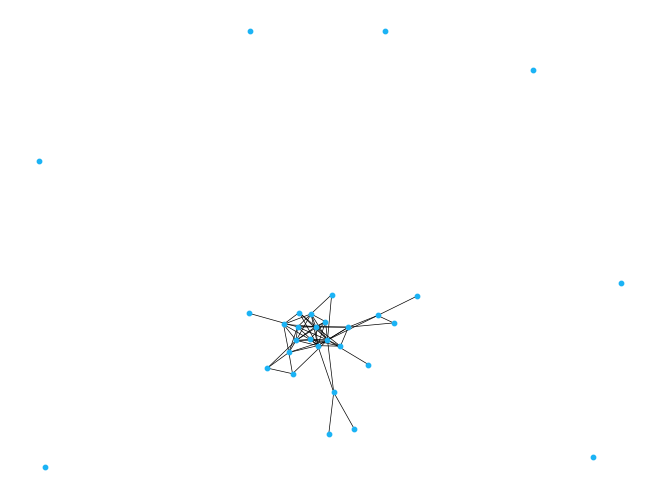

In [11]:
# Extract the sub-network of the known disease genes
disease_subnet = STRING_PPI.subgraph(disease_genes)
disease_subnet_pos = nx.spring_layout(disease_subnet, seed = 20)
nx.draw(disease_subnet, with_labels = False, pos = disease_subnet_pos, node_size = 10, node_color = "#1BB3F5", width = 0.5)

In [12]:
# Get basic properties of the network
print("Number of nodes:", disease_subnet.number_of_nodes())
print("Number of edges:", disease_subnet.number_of_edges())
print("Number of connected components:", nx.number_connected_components(disease_subnet))
print("Network modularity:", nx.algorithms.community.modularity(disease_subnet, nx.connected_components(disease_subnet)))
print("Number of isolated nodes:", nx.number_of_isolates(disease_subnet))
print("Number of self loops:", nx.number_of_selfloops(disease_subnet))
print("Average clustering coefficient:", nx.average_clustering(disease_subnet))
print("Network density:", nx.density(disease_subnet))

Number of nodes: 31
Number of edges: 64
Number of connected components: 8
Network modularity: 0.0
Number of isolated nodes: 7
Number of self loops: 0
Average clustering coefficient: 0.36083531164176325
Network density: 0.13763440860215054


In [13]:
# Find the top five nodes with highest centralities [takes long time]
degree_centrality = nx.degree_centrality(disease_subnet)
betweenness_centrality = nx.betweenness_centrality(disease_subnet)
closeness_centrality = nx.closeness_centrality(disease_subnet)

centrality_table = pd.DataFrame({"Degree centrality" : pd.Series(degree_centrality),
                                    "Betweenness" : pd.Series(betweenness_centrality),
                                    "Closeness centrality" : pd.Series(closeness_centrality)})

print(centrality_table.sort_values(by = "Degree centrality", ascending = False)[0:5].index.values)
print(centrality_table.sort_values(by = "Betweenness", ascending = False)[0:5].index.values)
print(centrality_table.sort_values(by = "Closeness centrality", ascending = False)[0:5].index.values)

['KRAS' 'EGFR' 'FGFR2' 'NOTCH1' 'FGFR1']
['KRAS' 'TTN' 'EGFR' 'PLK1' 'IGF1R']
['KRAS' 'EGFR' 'NOTCH1' 'FGFR2' 'IGF1R']


### Part C
- Are all the disease genes connected in the human interactome? If not, use Steiner tree to identify additional genes that may be required to connect the disconnected disease genes, if any.
- Extract sub-network from the human interactome consisting of the known disease genes and the additional genes identified from Steiner tree. These total set of genes will henceforth be called the extended disease gene list.

In [14]:
disease_steiner_tree = steiner_tree(STRING_PPI, terminal_nodes = disease_genes, method = "mehlhorn")

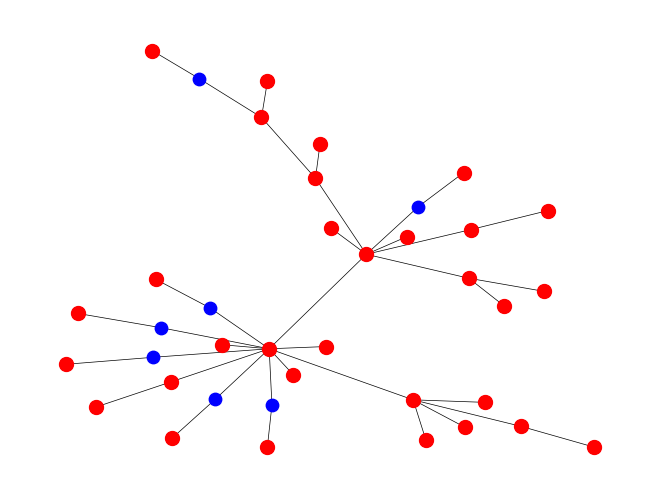

In [15]:
disease_steiner_tree_pos = nx.spring_layout(disease_steiner_tree, seed = 20)
nx.draw(disease_steiner_tree, with_labels = False, pos = disease_steiner_tree_pos, node_size = 80, node_color = "blue", edge_color = "black", width = 0.5)
nx.draw_networkx_nodes(disease_steiner_tree, disease_steiner_tree_pos, nodelist = disease_subnet.nodes(), node_size = 100, node_color = "red")


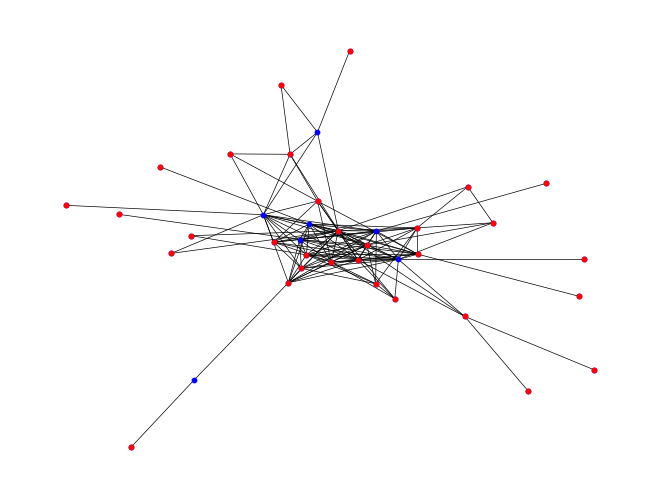

In [16]:
# Extract the sub-network of the extended disease gene list
disease_steiner_subnet = STRING_PPI.subgraph(disease_steiner_tree.nodes())
disease_steiner_subnet_pos = nx.spring_layout(disease_steiner_subnet, seed = 20)
nx.draw(disease_steiner_subnet, with_labels = False, pos = disease_steiner_subnet_pos, node_size = 10, node_color = "blue", width = 0.5)
nx.draw_networkx_nodes(disease_steiner_subnet, disease_steiner_subnet_pos, nodelist = disease_subnet.nodes(), node_size = 10, node_color = "red")


In [17]:
print("Number of genes in extended list: ", disease_steiner_subnet.number_of_nodes())

Number of genes in extended list:  38


In [18]:
# Get basic properties of the network
print("Number of nodes:", disease_steiner_subnet.number_of_nodes())
print("Number of edges:", disease_steiner_subnet.number_of_edges())
print("Number of connected components:", nx.number_connected_components(disease_steiner_subnet))
print("Network modularity:", nx.algorithms.community.modularity(disease_steiner_subnet, nx.connected_components(disease_steiner_subnet)))
print("Number of isolated nodes:", nx.number_of_isolates(disease_steiner_subnet))
print("Number of self loops:", nx.number_of_selfloops(disease_steiner_subnet))
print("Diameter of network:", nx.diameter(disease_steiner_subnet))
print("Average clustering coefficient:", nx.average_clustering(disease_steiner_subnet))
print("Average shortest path length:", nx.average_shortest_path_length(disease_steiner_subnet))
print("Network density:", nx.density(disease_steiner_subnet))

Number of nodes: 38
Number of edges: 137
Number of connected components: 1
Network modularity: 0.0
Number of isolated nodes: 0
Number of self loops: 0
Diameter of network: 5
Average clustering coefficient: 0.4671843421456424
Average shortest path length: 2.2972972972972974
Network density: 0.19487908961593173


### Part D
- Calculate the network separation between the targets of each drug and the disease genes. Based on the separation distance identify which drug would have the most therapeutic effect.
- Does the drug with highest therapeutic potential change if the proximity is calculated using known disease genes and the extended disease genes?
- Are the identified drugs currently in use for the disease in question?

In [19]:
# Read the drug list and their targets
drug_targets = pd.read_csv("Data/Exercise3_Drug_Targets.csv")
print("Number of drugs: ", len(drug_targets["drug_DrugBankID"].unique()))
drug_targets 

Number of drugs:  119


,drug_DrugBankID,target_geneSymbol,target_DrugBankID,target_name,organisms,drug_name
0,DB00136,VDR,BE0000779,Vitamin D3 receptor,Humans,Calcitriol
1,DB00153,VDR,BE0000779,Vitamin D3 receptor,Humans,Ergocalciferol
2,DB00153,CACNG1,BE0004902,Voltage-dependent calcium channel,Humans,Ergocalciferol
3,DB00184,CHRNA4,BE0000849,Neuronal acetylcholine receptor subunit alpha-4,Humans,Nicotine
4,DB00184,CHRNA7,BE0002341,Neuronal acetylcholine receptor subunit alpha-7,Humans,Nicotine
5,DB00184,CHRNB2,BE0000850,Neuronal acetylcholine receptor subunit beta-2,Humans,Nicotine
6,DB00184,CHRNA2,BE0000738,Neuronal acetylcholine receptor subunit alpha-2,Humans,Nicotine
7,DB00184,CHRNA9,BE0002343,Neuronal acetylcholine receptor subunit alpha-9,Humans,Nicotine
8,DB00184,CHRNA10,BE0000411,Neuronal acetylcholine receptor subunit alpha-10,Humans,Nicotine
9,DB00184,CYP19A1,BE0002090,Cytochrome P450 19A1,Humans,Nicotine


In [20]:
# Since our search space is PPI, we reduce the drugs to only those that has targets in the network
drug_targets = drug_targets.loc[drug_targets["target_geneSymbol"].isin(STRING_PPI.nodes())]
print("Number of drugs: ", len(drug_targets["drug_DrugBankID"].unique()))

Number of drugs:  115


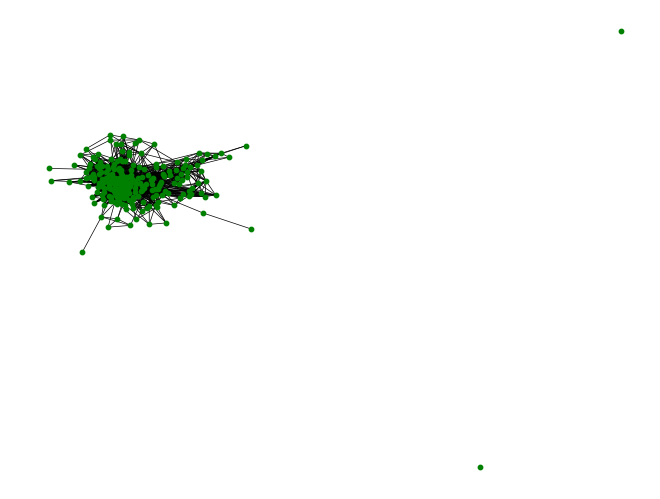

In [21]:
# Extract the sub-network of the drug targets
target_subnet = STRING_PPI.subgraph(drug_targets["target_geneSymbol"].unique())
target_subnet_pos = nx.spring_layout(target_subnet, seed = 20)
nx.draw(target_subnet, with_labels = False, pos = target_subnet_pos, node_size = 10, node_color = "green", width = 0.5)

In [22]:
# Prepare known drug-target associations 
drug2targets = {}
for drug in drug_targets["drug_DrugBankID"].unique(): 
    drug2targets[drug] = [e for e in drug_targets.loc[drug_targets["drug_DrugBankID"] == drug, "target_geneSymbol"]]

In [23]:
# Remove drugs with one known targets
# This is done since the separation distance calculation formula we used does not allow calculation if there is only one gene
drug2targets = {key: value for key, value in drug2targets.items() if len(np.unique(value)) > 1}

print("Number of drugs: ", len(drug2targets))

Number of drugs:  73


In [24]:
# Calculate network separation between the targets of known drugs and disease genes
result = pd.DataFrame()
for drug in drug2targets.keys():



    # Using the known disease genes --------
    genes_A = set(disease_subnet.nodes()) & set(STRING_PPI.nodes())
    genes_B = set(drug2targets[drug]) & set(STRING_PPI.nodes())

    d_A = separation.calc_single_set_distance(STRING_PPI,genes_A)
    d_B = separation.calc_single_set_distance(STRING_PPI,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(STRING_PPI,genes_A,genes_B)

    # calculate separation
    s_AB_knownGenes = d_AB - (d_A + d_B)/2



    # Using the extended disease genes --------
    genes_A = set(disease_steiner_subnet.nodes()) & set(STRING_PPI.nodes())
    genes_B = set(drug2targets[drug]) & set(STRING_PPI.nodes())

    d_A = separation.calc_single_set_distance(STRING_PPI,genes_A)
    d_B = separation.calc_single_set_distance(STRING_PPI,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(STRING_PPI,genes_A,genes_B)

    # calculate separation
    s_AB_extendedGenes = d_AB - (d_A + d_B)/2

    
    # Save the results as new row in the datafrma --------
    tmp = pd.DataFrame({"Drug" : drug,
                        "Number of targets" : len(genes_B),
                        "Separation (known)" : s_AB_knownGenes,
                        "Separation (extended)" : s_AB_extendedGenes},
                            index = [0])

    result = pd.concat([result, tmp])
    
result = result.sort_values(by = "Separation (extended)", ascending = True)
result = result.reset_index(drop = True)

In [25]:
# Get the drug ID to drug name mapping
drugID_2_drugName = drug_targets[["drug_DrugBankID", "drug_name"]].drop_duplicates(keep = "first")
drugID_2_drugName.shape

(115, 2)

In [26]:
# Add the drug names
result = result.merge(drugID_2_drugName, how = "left", left_on = "Drug", right_on = "drug_DrugBankID")
result

,Drug,Number of targets,Separation (known),Separation (extended),drug_DrugBankID,drug_name
0,DB00530,2,-0.097752,-0.050000,DB00530,Erlotinib
1,DB11986,3,-0.083491,-0.036585,DB11986,Entrectinib
2,DB08871,2,0.053763,0.100000,DB08871,Eribulin
3,DB08896,16,0.014756,0.129630,DB08896,Regorafenib
4,DB00203,3,0.063567,0.134146,DB00203,Sildenafil
5,DB08865,2,0.144673,0.175000,DB08865,Crizotinib
6,DB01254,14,0.073605,0.175824,DB01254,Dasatinib
7,DB00641,3,0.092979,0.182927,DB00641,Simvastatin
8,DB12267,8,0.092225,0.195652,DB12267,Brigatinib
9,DB00945,14,0.149002,0.197802,DB00945,Acetylsalicylic acid
